In [1]:
import torch
from torchvision.models import resnet50
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

/home/tkg5kq/.conda/envs/video2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.insert(0, "./../explain/ml-no-token-left-behind/external/tamingtransformers")
sys.path.append("./../explain/ml-no-token-left-behind/external/TransformerMMExplainability")
# from ntlb import load_classifier
from torch import nn
from dotmap import DotMap
import yaml
from modules.Visual_Prompt import visual_prompt
from CLIP.clip import clip
from prompt import *

/home/tkg5kq/.conda/envs/video2/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [3]:

def load_classifier(pretrain, model, fusion_model):
    if os.path.isfile(pretrain):
        print(("=> loading checkpoint '{}'".format(pretrain)))
        checkpoint = torch.load(pretrain)
        model.load_state_dict(checkpoint['model_state_dict'])
        fusion_model.load_state_dict(checkpoint['fusion_model_state_dict'])
        del checkpoint
    else:
        print(("=> no checkpoint found at '{}'".format(pretrain)))

    return model, fusion_model

def get_models(config_file):
    # config_file = '/scratch/tkg5kq/sandbox/bounding_box/comparison/ActionCLIP/exp/clip_k400/ViT-B/32/education6/FULL_BEST_ACTION/generic_prompts_bb_train.yaml'
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
    config = DotMap(config)

    device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
    model, clip_state_dict = clip.load(config.network.arch, device=device, jit=False, tsm=config.network.tsm,
                                                    T=config.data.num_segments, dropout=config.network.drop_out,
                                                    emb_dropout=config.network.emb_dropout)  # Must set jit=False for training  ViT-B/32


    fusion_model = visual_prompt(config.network.sim_header, clip_state_dict, config.data.num_segments)

    model_text = TextCLIP(model)
    model_image = ImageCLIP(model)

    model_text = torch.nn.DataParallel(model_text).cuda()
    model_image = torch.nn.DataParallel(model_image).cuda()
    fusion_model = torch.nn.DataParallel(fusion_model).cuda()
    model, fusion_model = load_classifier(config.pretrain, model, fusion_model)
    model_image.requires_grad_(True)
    model_text.requires_grad_(True)
    fusion_model.requires_grad_(True)
    model.requires_grad_(True)
    return model, config, fusion_model, model_text, model_image


In [4]:
config_file = 'exp/clip_k400/ViT-B/32/20250202_172300_BEST_78percent/generic_prompts_bb_train.yaml'
model, config, fusion_model, model_text, model_image = get_models(config_file)

dropout used:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
dropout used:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
loading clip pretrained model!
layer=6
=> loading checkpoint '/sfs/weka/scratch/tkg5kq/sandbox/bounding_box/comparison/ActionCLIP/exp/clip_k400/ViT-B/32/20250202_172300_BEST_78percent/model_best.pt'


In [9]:
def get_aug(training, config):
    # input_mean=[0.5, 0.5, 0.5]
    # input_std=[0.5, 0.5, 0.5]
    input_mean = [0.48145466, 0.4578275, 0.40821073]
    input_std = [0.26862954, 0.26130258, 0.27577711]
    scale_size = config.data.input_size * 256 // 224
    if training:
        unique = torchvision.transforms.Compose([
                                                 GroupMultiScaleCrop(config.data.input_size, [1, .875, .75, .66]),
                                                 GroupRandomHorizontalFlip(is_sth='some' in config.data.dataset),
                                                 GroupRandomColorJitter(p=0.8, brightness=0.4, contrast=0.4,
                                                                        saturation=0.2, hue=0.1),
                                                 GroupRandomGrayscale(p=0.2),
                                                 GroupGaussianBlur(p=0),
                                                 GroupSolarization(p=0)]
                                                )
    else:
        unique = torchvision.transforms.Compose([
                                                 GroupScale(scale_size),
                                                 GroupCenterCrop(config.data.input_size)
                                                 ])

    common = torchvision.transforms.Compose([GroupStack(roll=False),
                                             GroupToTorchFormatTensor(div=True),
                                            #  GroupNormalize(input_mean,
                                            #                 input_std)
                                                            ])
    return torchvision.transforms.Compose([unique, common])

from datasets import Action_DATASETS, Action_DATASETS_orig
transform_val = get_aug(False, config)
def collate_fn(batch):
    cropped_videos, images, bbs, labels = zip(*batch)
    # Check the labels for bb
    cropped_videos = torch.stack(cropped_videos) 
    images = torch.stack(images) 
    labels = torch.tensor(labels)
    return cropped_videos, images, labels

val_data = Action_DATASETS_orig(
                config.data.val_list,
                config.data.label_list, 
                random_shift=False,
                num_segments=config.data.num_segments,
                image_tmpl=config.data.image_tmpl,
                transform=transform_val)
val_loader = DataLoader(
                val_data,
                batch_size=config.data.batch_size,
                num_workers=config.data.workers,
                shuffle=False,
                pin_memory=False,
                drop_last=True,
                collate_fn=collate_fn)

In [10]:
model = model.eval()
classes, num_text_aug, text_dict = text_prompt(val_data, file_name=config.prompt)


In [38]:

import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
import io
def plot_bbox(image, data, i):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        print(bbox)
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=4, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # # Annotate the label  
        # plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    # buf = io.BytesIO()
    # plt.savefig(buf, format='png')
    # buf.seek(0)
    # # Open the buffer as a PIL Image
    # image = Image.open(buf)
    plt.savefig(f'./images/bbs/bb{i}.png', bbox_inches='tight', pad_inches=0) 

[0.0, 0.0, 136.85000610351562, 220.77435302734375]
[0.0, 0.0, 136.85000610351562, 220.77435302734375]
[0.0, 0.3585069477558136, 136.63999938964844, 221.1328582763672]
[0.0, 0.3585069477558136, 136.63999938964844, 221.1328582763672]
[0.0, 1.4340277910232544, 100.9574966430664, 222.2083740234375]
[0.0, 1.4340277910232544, 100.9574966430664, 222.2083740234375]
[0.0, 1.4340277910232544, 100.15103149414062, 222.2083740234375]
[0.0, 1.4340277910232544, 100.15103149414062, 222.2083740234375]
[0.0, 1.4340277910232544, 100.15103149414062, 222.2083740234375]
[0.0, 1.4340277910232544, 100.15103149414062, 222.2083740234375]
[0.0, 0.00030381945543922484, 145.9205780029297, 220.774658203125]
[0.0, 0.00030381945543922484, 145.9205780029297, 220.774658203125]
[0.0, 0.7170138955116272, 138.25987243652344, 221.49136352539062]
[0.0, 0.7170138955116272, 138.25987243652344, 221.49136352539062]
[0.0, 0.7170138955116272, 88.26285552978516, 221.49136352539062]
[0.0, 0.7170138955116272, 88.26285552978516, 221.

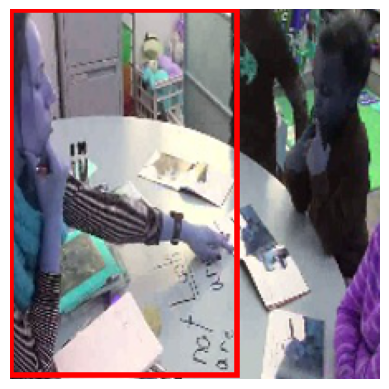

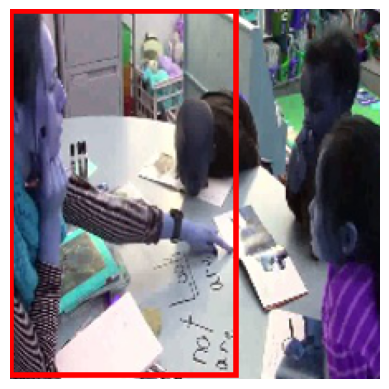

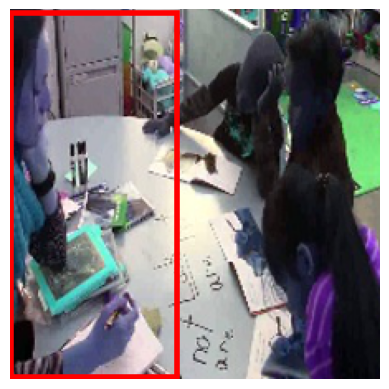

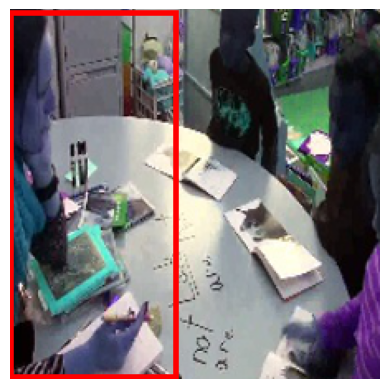

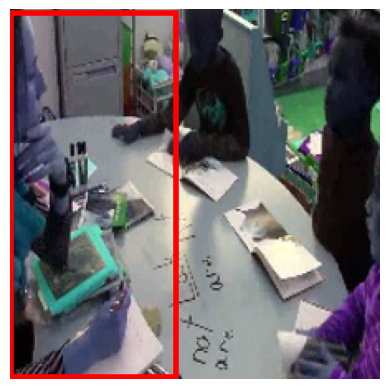

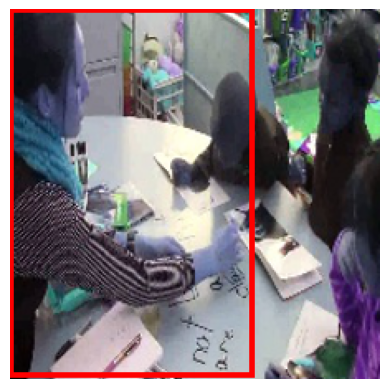

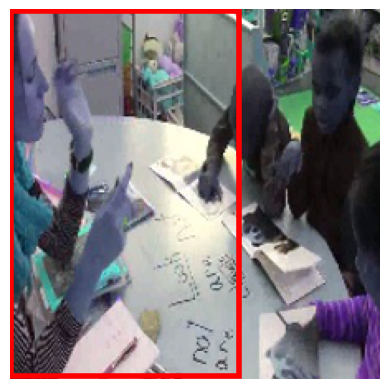

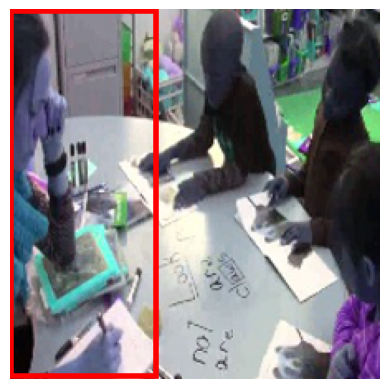

In [39]:
import torch
import torchvision.transforms as transforms
from PIL import Image

vid_num = 3
cropped_vid, vid, bbs, label = val_data[vid_num]

transform = transforms.ToPILImage()
vid = vid.reshape(8, 3, 224, 224)
cropped_vid = cropped_vid.reshape(8, 3, 224, 224)
for i, (frame, frame_cropped, bb) in enumerate(zip(vid, cropped_vid, bbs)):
    image = transform(frame)
    image_cropped = transform(frame_cropped)
    # plt.figure()
    # plt.imshow(image)
    print(bb.tolist())
    data = {'bboxes': [bb.tolist()], 'labels':[f'Using a Book']}
    plot_bbox(image, data, i)
    # image.save(f'./images/frames/image{i}.jpg')
    # image_cropped.save(f'./images/cropped/cropped{i}.jpg')
